Part 1: Data Cleaning, EDA and Feature Engineering  

1. Train Data Cleaning, EDA and Feature Engineering
2. Weather Data Cleaning, EDA and Feature Engineering
3. Spray Data Cleaning, EDA and Feature Engineering
4. Combined EDA and Feature Engineering, Pre-Processing  

**Part 2: Modeling**  

5. **Modelling, Iteration, Limitations, CBA, Recommendations & Conclusion**  

## Table of Contents
1. [Problem Statement](#1.-Problem-Statement)  
2. [Module Imports](#2.-Module-Imports)   
3. [Function Definitions](#3.-Function-Definitions)  
4. [Read CSVs](#4.-Read-CSVs)
5. [Baseline model](#5.-Baseline-model)
6. [Metrics for model evaluation](#6.-Metrics-for-model-evaluation)
7. [Modeling](#7.-Modeling)
8. [Kaggle submissions](#8.-Kaggle-submissions)
9. [Limitations](#9.-Limitations)
10. [Cost Benefit Analysis](#10.-Cost-Benefit-Analysis)
11. [Recommendations and Conclusions](#11.-Recommendations-and-Conclusions)

## 1. Problem Statement
[Return to top](#Table-of-Contents)

- Introduction  
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.  


- Problem Statement  
Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.  


- Stakeholders:
    - Primary stakeholders: City of Chicago and the Chicago Department of Public Health (CDPH)  
    - Secondary stakeholders: General public for awareness

## 2. Module Imports
[Return to top](#Table-of-Contents)

In [1]:
# Standard imports
import numpy as np # Version 1.20.1
import pandas as pd # Version 1.2.4
# Pandas settings
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", 200)

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# Please reduce "DPI" values below if plots take too long to display 
# Higher values make plots remain clear when zoomed in
plt.rcParams['figure.dpi'] = 200
# The lowest recommended value is 200 for A4 size print legibility 
# The recommended value is 600 for 'photograph-like' legibility
%matplotlib inline

# Time Series imports
import datetime as dt # Version 2.8.1

# Modelling imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Warnings
import warnings
warnings.simplefilter(action='ignore')

## 3. Function Definitions
[Return to top](#Table-of-Contents)

In [2]:
# Function to return name of dataframes
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# Function for optimistic modelling 
def optimistic_model(clf, clf_params, X, y): 
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,stratify = y,random_state = 42)  
    pipe = Pipeline(steps = [('ss', StandardScaler()),('sm', SMOTE(random_state = 42)),('clf', clf)])

    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1)
    
    grid.fit(X_train,y_train)
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_train_preds = grid.predict(X_train)
    y_test_preds = grid.predict(X_test)
   
    scores['Train ROC-AUC Score'] = roc_auc_score(y_train, y_train_preds.ravel())

    # # Storing results for Test
    scores['Val ROC-AUC Score'] = roc_auc_score(y_test, y_test_preds.ravel())
    scores['Best Parameters'] = grid.best_params_
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    optimisticresult.append(scores)

    return pipe

# Function for realistic modelling
def realistic_model(clf, clf_params, X, y):
    # Train Test Split (Walk forward Implementation)
    train_size = int(len(X) * 0.80)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]
    tscv = TimeSeriesSplit(n_splits = 3,test_size = 4)
    
    pipe = Pipeline(steps = [('ss', StandardScaler()),('sm', SMOTE(random_state = 42)),('clf', clf)])

    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        cv= tscv,
        n_jobs=-1)
    
    grid.fit(X_train,y_train)
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_train_preds = grid.predict(X_train)
    y_test_preds = grid.predict(X_test)
   
    scores['Train ROC-AUC Score'] = roc_auc_score(y_train, y_train_preds.ravel())

    # # Storing results for Test
    scores['Val ROC-AUC Score'] = roc_auc_score(y_test, y_test_preds.ravel())
    scores['Best Parameters'] = grid.best_params_
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    scores['Train set Used'] = get_df_name(X) 
    scores['Val set used'] = get_df_name(y)
    realisticresult.append(scores) 
    
    return pipe

## 4. Read CSVs
[Return to top](#Table-of-Contents)

In [3]:
train_combined = pd.read_csv('../data/train_combined.csv',index_col=[0])
test_combined = pd.read_csv('../data/test_combined.csv',index_col=[0])
submission = pd.read_csv('../data/sampleSubmission.csv')

In [4]:
print("Train :", train_combined.shape)
print("Predict :", test_combined.shape)
print("Submit :",submission.shape)

Train : (8610, 43)
Predict : (116293, 42)
Submit : (116293, 2)


In [5]:
train_combined.columns
# click ... to see output

Index(['Species', 'Latitude', 'Longitude', 'WnvPresent', 'Tmin', 'DewPoint',
       'Sunrise', 'Wet_NoWet', 'PrecipTotal', 'StnPressure', 'ResultSpeed',
       'ResultDir', 'Tmin_rm7_lag1', 'Tmin_rm7_lag2', 'Tmin_rm7_lag3',
       'Tmin_rm7_lag4', 'DewPoint_rm7_lag1', 'DewPoint_rm7_lag2',
       'DewPoint_rm7_lag3', 'DewPoint_rm7_lag4', 'Sunrise_rm7_lag1',
       'Sunrise_rm7_lag2', 'Sunrise_rm7_lag3', 'Sunrise_rm7_lag4',
       'PrecipTotal_rm7_lag1', 'PrecipTotal_rm7_lag2', 'PrecipTotal_rm7_lag3',
       'PrecipTotal_rm7_lag4', 'StnPressure_rm7_lag1', 'StnPressure_rm7_lag2',
       'StnPressure_rm7_lag3', 'StnPressure_rm7_lag4', 'ResultSpeed_rm7_lag1',
       'ResultSpeed_rm7_lag2', 'ResultSpeed_rm7_lag3', 'ResultSpeed_rm7_lag4',
       'ResultDir_rm7_lag1', 'ResultDir_rm7_lag2', 'ResultDir_rm7_lag3',
       'ResultDir_rm7_lag4', 'Year', 'Month', 'WeekofYear'],
      dtype='object')

In [6]:
test_combined.columns
# click ... to see output

Index(['Species', 'Latitude', 'Longitude', 'Tmin', 'DewPoint', 'Sunrise',
       'Wet_NoWet', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir',
       'Year', 'Month', 'WeekofYear', 'Tmin_rm7_lag1', 'Tmin_rm7_lag2',
       'Tmin_rm7_lag3', 'Tmin_rm7_lag4', 'DewPoint_rm7_lag1',
       'DewPoint_rm7_lag2', 'DewPoint_rm7_lag3', 'DewPoint_rm7_lag4',
       'Sunrise_rm7_lag1', 'Sunrise_rm7_lag2', 'Sunrise_rm7_lag3',
       'Sunrise_rm7_lag4', 'PrecipTotal_rm7_lag1', 'PrecipTotal_rm7_lag2',
       'PrecipTotal_rm7_lag3', 'PrecipTotal_rm7_lag4', 'StnPressure_rm7_lag1',
       'StnPressure_rm7_lag2', 'StnPressure_rm7_lag3', 'StnPressure_rm7_lag4',
       'ResultSpeed_rm7_lag1', 'ResultSpeed_rm7_lag2', 'ResultSpeed_rm7_lag3',
       'ResultSpeed_rm7_lag4', 'ResultDir_rm7_lag1', 'ResultDir_rm7_lag2',
       'ResultDir_rm7_lag3', 'ResultDir_rm7_lag4'],
      dtype='object')

It seems that the columns ordering are not uniform. We will reset the index for each dataframe.

In [7]:
train_combined = train_combined[['Species', 'Latitude', 'Longitude', 'Tmin', 'DewPoint',
       'Sunrise', 'Wet_NoWet', 'PrecipTotal', 'StnPressure', 'ResultSpeed',
       'ResultDir', 'Tmin_rm7_lag1', 'Tmin_rm7_lag2', 'Tmin_rm7_lag3',
       'Tmin_rm7_lag4', 'DewPoint_rm7_lag1', 'DewPoint_rm7_lag2',
       'DewPoint_rm7_lag3', 'DewPoint_rm7_lag4', 'Sunrise_rm7_lag1',
       'Sunrise_rm7_lag2', 'Sunrise_rm7_lag3', 'Sunrise_rm7_lag4',
       'PrecipTotal_rm7_lag1', 'PrecipTotal_rm7_lag2', 'PrecipTotal_rm7_lag3',
       'PrecipTotal_rm7_lag4', 'StnPressure_rm7_lag1', 'StnPressure_rm7_lag2',
       'StnPressure_rm7_lag3', 'StnPressure_rm7_lag4', 'ResultSpeed_rm7_lag1',
       'ResultSpeed_rm7_lag2', 'ResultSpeed_rm7_lag3', 'ResultSpeed_rm7_lag4',
       'ResultDir_rm7_lag1', 'ResultDir_rm7_lag2', 'ResultDir_rm7_lag3',
       'ResultDir_rm7_lag4', 'Year', 'Month', 'WeekofYear','WnvPresent']]
test_combined = test_combined[['Species', 'Latitude', 'Longitude', 'Tmin', 'DewPoint',
       'Sunrise', 'Wet_NoWet', 'PrecipTotal', 'StnPressure', 'ResultSpeed',
       'ResultDir', 'Tmin_rm7_lag1', 'Tmin_rm7_lag2', 'Tmin_rm7_lag3',
       'Tmin_rm7_lag4', 'DewPoint_rm7_lag1', 'DewPoint_rm7_lag2',
       'DewPoint_rm7_lag3', 'DewPoint_rm7_lag4', 'Sunrise_rm7_lag1',
       'Sunrise_rm7_lag2', 'Sunrise_rm7_lag3', 'Sunrise_rm7_lag4',
       'PrecipTotal_rm7_lag1', 'PrecipTotal_rm7_lag2', 'PrecipTotal_rm7_lag3',
       'PrecipTotal_rm7_lag4', 'StnPressure_rm7_lag1', 'StnPressure_rm7_lag2',
       'StnPressure_rm7_lag3', 'StnPressure_rm7_lag4', 'ResultSpeed_rm7_lag1',
       'ResultSpeed_rm7_lag2', 'ResultSpeed_rm7_lag3', 'ResultSpeed_rm7_lag4',
       'ResultDir_rm7_lag1', 'ResultDir_rm7_lag2', 'ResultDir_rm7_lag3',
       'ResultDir_rm7_lag4', 'Year', 'Month', 'WeekofYear']]

In [8]:
# Define X and Y for tr01
X = train_combined.drop(columns=['WnvPresent'])
y = train_combined['WnvPresent']

## 5. Baseline model
[Return to top](#Table-of-Contents)

**Baseline model with original positive class distribution (Imbalanced)**  

In [9]:
print(" Positive class")
print(y.value_counts(normalize = True))

 Positive class
0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64


In [10]:
# Train test split for quick and dirty model
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.2, random_state = 42 , stratify = y)

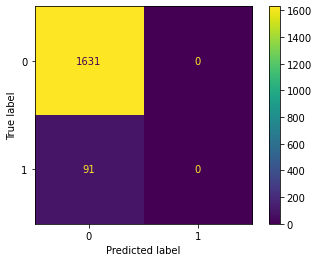

In [11]:
# Baseline Logreg with imbalanced class distribution
lr = LogisticRegression(random_state = 42,max_iter=1000)
lr.fit(X_train, y_train)
#predict test dataset
y_preds = lr.predict(X_test)
#confusion matrix
plot_confusion_matrix(lr, X_test, y_test);

In [12]:
# Print tn, fp, fn, tp values
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print('True Negative: ',tn)
print('False Positive: ',fp) 
print('False Negative: ',fn)
print('True Positive: ',tp)

True Negative:  1631
False Positive:  0
False Negative:  91
True Positive:  0


In [13]:
print(classification_report(y_test, y_preds))
print('Train Score: ', lr.score(X_train, y_train)),
print('Test Score: ', lr.score(X_test, y_test)),
print('ROC_AUC Score: ', roc_auc_score(y_test, y_preds.ravel()))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1631
           1       0.00      0.00      0.00        91

    accuracy                           0.95      1722
   macro avg       0.47      0.50      0.49      1722
weighted avg       0.90      0.95      0.92      1722

Train Score:  0.9468641114982579
Test Score:  0.9471544715447154
ROC_AUC Score:  0.5


Using our quick and dirty Logistic Regression as the baseline model with our imbalanced dataset, there is 0 predicted positive cases. Reffering to the confusion matrix, we missed 91 actual positive cases due to the trained model's reluctance caused by the imbalanced dataset. While accuracy scores were great, ROC-AUC score was a measly 50%. To overcome the issue, we can use synthetic minority oversampling technique(SMOTE) to upsample our data to achieve balanced class distribution.

**Baseline model with upsampled positive class distribution (Balanced)**

In [14]:
# Upsampling positive class
smote = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
# Achieving Balanced class distribution after upsampling with SMOTE
print(y_train_smt.value_counts(normalize = True))

1    0.5
0    0.5
Name: WnvPresent, dtype: float64


Let's use our upsampled data with our quick and dirty model for a new baseline.

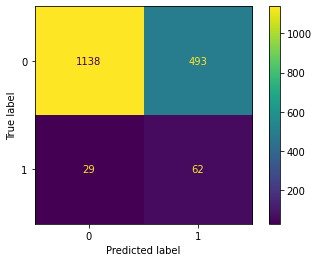

In [15]:
# Baseline Logreg with imbalanced class distribution
lr = LogisticRegression(random_state = 42,max_iter=1000)
lr.fit(X_train_smt, y_train_smt)

# predict test dataset
y_preds = lr.predict(X_test)

# plot confusion matrix
plot_confusion_matrix(lr, X_test, y_test);

In [16]:
# Print tn, fp, fn, tp values
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print('True Negative: ',tn)
print('False Positive: ',fp) 
print('False Negative: ',fn)
print('True Positive: ',tp)

True Negative:  1138
False Positive:  493
False Negative:  29
True Positive:  62


In [17]:
print(classification_report(y_test, y_preds))
print('Train Score: ', lr.score(X_train, y_train)),
print('Test Score: ', lr.score(X_test, y_test)),
print('ROC_AUC Score: ', roc_auc_score(y_test, y_preds.ravel()))

              precision    recall  f1-score   support

           0       0.98      0.70      0.81      1631
           1       0.11      0.68      0.19        91

    accuracy                           0.70      1722
   macro avg       0.54      0.69      0.50      1722
weighted avg       0.93      0.70      0.78      1722

Train Score:  0.6867015098722415
Test Score:  0.6968641114982579
ROC_AUC Score:  0.6895250672074706


With upsampled data, the initial reluctance of the earlier model caused by training with an imbalanced dataset is reduced, with a total of 574 positive cases predicted (FP:510, TP: 64). We were able to capture 70% of confirmed WNV traps this time, measuring the potential saved costs compared against extra expenditure owing to spraying costs incurred will be done later in the cost benefit analysis.  

We also note that the benchmark (ROC-AUC is 69.5%) for our upsampled dataset, subsequent models with ROC-AUC less than 69.5% will be rejected.

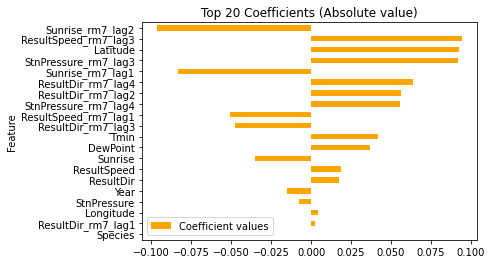

In [18]:
# Extracting coefficient values
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient values'] = pd.Series(lr.coef_.tolist()[0])
coeff.rename(columns={0:"Feature"}, inplace=True)

#we will use this for sorting
coeff['abs_val'] = abs(coeff['Coefficient values'])

#top 20 features
coeff_20 = coeff.sort_values(by ='abs_val', ascending=True)[:20]
coeff_20.sort_values(by='abs_val').plot(kind = 'barh',y='Coefficient values',x='Feature',color = 'orange', title = 'Top 20 Coefficients (Absolute value)');


---

## 6. Metrics for model evaluation
[Return to top](#Table-of-Contents)

While the `AUC-ROC` score will be evaluated for purposes of the Kaggle, the more important metric to optimize for the business case is false negatives. False negatives happen when the model wrongly predicts no presence of WNV when it is actually present. It will be important to ensure minimal false negatives these may translate to outbreaks causing enormous strain on public healthcare resources and producitivity loss.     

The model metric allowing us to measure model performance with regards to minimizing false negatives is `Recall` score.  
Ultimately, when it comes to choosing the model for our business case, we will prioritize choosing models with the high recall score first, followed by high ROC-AUC scores.

## 7. Modeling
[Return to top](#Table-of-Contents)

Here are the models chosen for modelling, coupled with reasons for choosing them:
- **LogisticRegression**
    - Easy to understand
    - Interpretability 
    - Efficient to train
- **K-Nearest Neighbours Classifier**
    - No assumptions have to be made
    - Adaptable to quickly changing training data 
- **Decision Tree Classifier**
    - Interpretability
    - Minimal pre-processing
    - Decent perf. despite violation of assumptions by the true model of data generation
- **Random Forest Classifier**
    - Robust to outliers
    - Lower risk of overfitting, compared to Decision Trees
    - Efficient on larger dataset
- **Adaboost Classifier**
    - Built on shortcomings of Decision Trees
    - Improved accuracy compared to 'weak' classifiers
    - Minimal hyperparameter to tune

We will be using GridSearchCV to perform hyperparameter tuning at the same time.

In [19]:
#Configuring parameters for above mentioned models

# LogisticRegression
lr = LogisticRegression()
lr_params = {
    'clf__random_state': [42],
    'clf__n_jobs': [-1],
    'clf__C': [0.001, 0.25075, 0.5005],
    'clf__l1_ratio': [0, 0.25, 0.5],
    'clf__max_iter': [750,1000],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver' : ['liblinear']
}

# K-Nearest Neighbours Classifier
knn = KNeighborsClassifier()
knn_params = {
    'clf__n_neighbors' : [3,4,5,7],
    'clf__p': [1,2]
}

# Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc_params = {
    'clf__random_state': [42],
    'clf__max_depth': [2, 3, 5, 10],
    'clf__min_samples_leaf': [2, 5, 8],
    'clf__criterion': ['gini', 'entropy']
}
   
# Random Forest Classifier
rfc = RandomForestClassifier()
rfc_params = {
    'clf__random_state': [42],
    'clf__n_jobs': [-1],
    'clf__n_estimators': [15, 30, 45],
    'clf__max_depth': [4, 6, 8, 10]
}

# Ada Boost Classifier
ada = AdaBoostClassifier()
ada_params = {
    'clf__random_state': [42],
    'clf__n_estimators':[50,75,100], 
    'clf__learning_rate':[1,0.5,0.1,0.05,0.01]
}

# List of classifiers & params
classifiers = [
    (lr, lr_params),
    (knn, knn_params),
    (dtc, dtc_params),
    (rfc, rfc_params),
    (ada, ada_params),
]

In [20]:
# Initializing empty list to store gridsearch results
optimisticresult = []

In [21]:
# Run GS on all models across all trainsets

# Train-test split, Scaling and SMOTE is applied onto X and y which is the train dataset 
# followed by being trained using respective classifier embedded as a pipeline inside the function
# refer to the Function Definition section to see what happens under the hood

for (clf, clf_params) in classifiers:
    optimistic_model(clf, clf_params, X, y)
#click ... to view output

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Classifier: LogisticRegression()
Best Parameters:
{'clf__C': 0.5005, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classifier: KNeighborsClassifier()
Best Parameters:
{'clf__n_neighbors': 7, 'clf__p': 2}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Classifier: DecisionTreeClassifier()
Best Parameters:
{'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__random_state': 42}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: RandomForestClassifier()
Best Parameters:
{'clf__max_depth': 8, 'clf__n_estimators': 30, 'clf__n_jobs': -1, 'clf__random_state': 42}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Classifier: AdaBoostClassifier()
Best Parameters:
{'clf__learning_rate': 0.5, 'clf__n_estimators'

In [22]:
# View results of GSCV with best parameters for each of the model
optimisticresult = pd.DataFrame(optimisticresult).sort_values(by='Val ROC-AUC Score', ascending=False).reset_index(drop=True)
optimisticresult

,Classifier,Train ROC-AUC Score,Val ROC-AUC Score,Best Parameters,F1,Precision,Recall,Accuracy
0,AdaBoostClassifier(),0.754013,0.789676,"{'clf__learning_rate': 0.5, 'clf__n_estimators': 50, 'clf__random_state': 42}",0.246490,0.143636,0.868132,0.719512
1,DecisionTreeClassifier(),0.767364,0.772108,"{'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__random_state': 42}",0.214470,0.121523,0.912088,0.646922
2,RandomForestClassifier(),0.796007,0.762817,"{'clf__max_depth': 8, 'clf__n_estimators': 30, 'clf__n_jobs': -1, 'clf__random_state': 42}",0.233438,0.136280,0.813187,0.717770
3,LogisticRegression(),0.745448,0.751144,"{'clf__C': 0.5005, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}",0.217077,0.125000,0.824176,0.685830
4,KNeighborsClassifier(),0.883412,0.696788,"{'clf__n_neighbors': 7, 'clf__p': 2}",0.234513,0.146814,0.582418,0.799071


## 8. Kaggle submissions
[Return to top](#Table-of-Contents)

In [23]:
# sub = pd.DataFrame(ada.predict_proba(test_combined)[:,1], columns = ['WnvPresent'])
# sub.set_index(np.arange(1, test_combined.shape[0] + 1), inplace=True)
# sub = sub.reset_index().rename(columns = {'index':'Id'})
# sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
# sub.to_csv('../data/submission_ada.csv', index = False)

# Commented to prevent creating submission result for viewer device

**Analysis for GSCV models**

Top Kaggle model (ROC-AUC) Score:  
 - **AdaBoostClassifier**    

Top busines model (Recall) Score:  
 - **AdaBoostClassifier**

Looking at the results of our gridsearch, the AdaBoostClassifier tops both our Kaggle and business case metric (ROC-AUC and Recall) with the scores of ~0.778 and ~0.901 respectively. 
We will use the AdaBoostClassifier model predictions for submission to Kaggle.

Kaggle score:
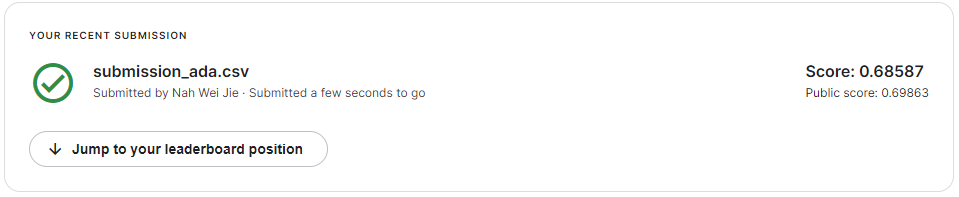

Let's take a look at the top coefficients from the AdaBoostClassifier.

**Top Coefficients**

In [24]:
ada = AdaBoostClassifier(random_state = 42, n_estimators = 100, learning_rate = 0.1).fit(X_train_smt, y_train_smt)

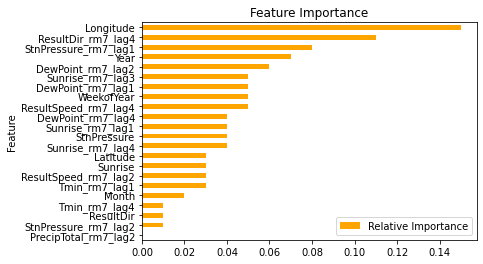

In [25]:
# Extracting coefficient values
coeff = pd.DataFrame(ada.feature_names_in_)
coeff['Relative Importance'] = pd.Series(ada.feature_importances_)
coeff.rename(columns={0:"Feature"}, inplace=True)

#Top 10 features
coeff_20 = coeff.sort_values(by ='Relative Importance', ascending=True)
coeff_20.sort_values('Relative Importance')[20:].plot(kind = 'barh',y='Relative Importance',x='Feature',color = 'orange', title = 'Feature Importance');

---

## 9. Limitations
[Return to top](#Table-of-Contents)

While it seems that the models are doing decently well, during EDA we have identified certain features prior which have shown trends and seasonalities. Resultant of that, there are assumptions made that where past data are correlated to the present. Not only is past data correlated, another assumption is that the most recent past data have a natural tendency to be the most correlated. This is also seen in the feature importance portion, where most if not all lagged weather features are better indicators than the present weather features. 

**Look Ahead Bias**  
Another violation made to our modelling approach is the [look-ahead bias](https://www.investopedia.com/terms/l/lookaheadbias.asp#:~:text=What%20Is%20the%20Look%2DAhead,in%20the%20study%20or%20simulation.), which occurs by using information or data in a study or simulation that would not have been known or available during the period being analyzed. This can lead to inaccurate results in the study or simulation.

We made this violation as the train dataset contained features for the following years: 2007,2009,2011,2013. Our models were trained using four alternating years of training data. Consequently, we are predicting for the years: 2008,2010,2012,2014. Following what was stated for the look ahead bias, we have used data for future years to predict the presence of WNV (i.e 2008, was predicted using data from 2009,2011,2013, so on...). The "reliable" predictions where future data was not introduced is probably year 2014.

**Traditional Cross Validation's role in introducing bias**  

This is cross validation as we commonly understand it:  
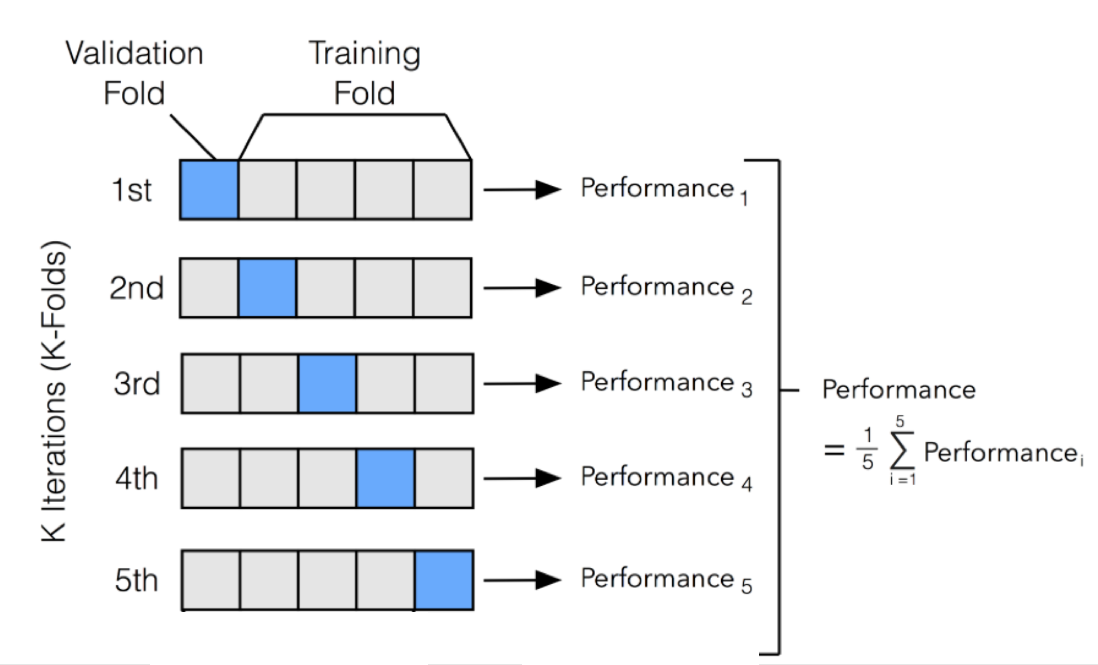

If the data was indexed base on the date of the records, we can say that first fold will contain mostly information from 2007, and the last fold will contain mostly information from 2013. By performing cross validation, or shuffling the data during the train test split, we would have either broken the serial relationship of the precendent rows or introduced some form of look ahead bias where future data has been used to predict the past by the time cross validation is complete.

**Look ahead validation**  
In practice, we very likely will retrain our model at an interview  new data becomes available.

Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
1. The model makes a prediction for the next time step.
2. The prediction is stored or evaluated against the known value.
3. The window is expanded to include the known value and the process is repeated (go to step 1.)  

Because this methodology involves moving along the time series one-time step at a time, it is often called Walk Forward Testing or Walk Forward Validation.

This also brings upon a problem where your training dataset is ever expanding, while years which are too far behind becomes more of a crutch than an aid in the modelling process.  

This is how it looks visually 
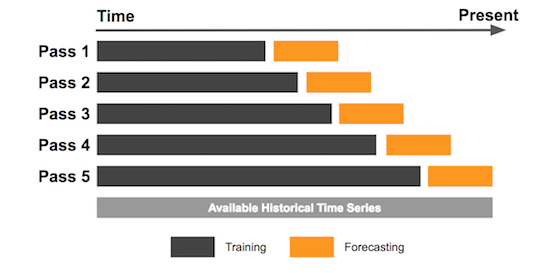


**Introducing a Sliding Window**

To counteract this, we can introduce a sliding or expanding window to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast. 
  
Visually this is how it looks like:  
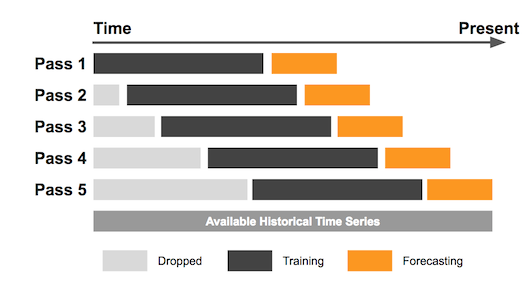



Below is an attempt of implementing the methods listed above to our project:

Here is an outline of how the train test datasets will be transformed:
- Train data to be split into four sets consisting of the following years:
    - train1 (2007)
    - train2 (2007,2009)
    - train3 (2007,2009,2011)
    - train4 (2009,2011,2013)  

- Test data to be split into four sets consisting of the following years:
    - test1 (2008)
    - test2 (2010)
    - test3 (2012)
    - test4 (2014)  

In [26]:
# Splitting of train dataset into the outlined years
tr01 = train_combined[train_combined['Year'] == 2007]
tr02 = train_combined[(train_combined['Year'] == 2007) | (train_combined['Year'] == 2009)]
tr03 = train_combined[(train_combined['Year'] == 2007) | (train_combined['Year'] == 2009) | (train_combined['Year'] == 2011)]
# Note that in trainset four (tr04) 2007 is not included, the 'window' is capped at 3 years
tr04 = train_combined[(train_combined['Year'] == 2009) | (train_combined['Year'] == 2011) | (train_combined['Year'] == 2013)]

In [27]:
print(tr01.shape,tr02.shape,tr03.shape,tr04.shape)

(2837, 43) (4758, 43) (6552, 43) (5773, 43)


By limiting the maximum number of years in a training set to 3 years, this will allow us to keep only the three most recent years and also prevent an ever expanding training set which will become more computationally intensive in both resource and time to maintain and train.    

It should also be important to note the above methodology cannot be applied to this project as ideally once a year has passed in the present we would have obtained the ground truth for that year for both comparing model performance and for retraining the train sets to include years passed (we did not include test years passed as the training data for subsequent years).

With this methodology, every model which was originally used for training will have be trained four times for each trainset to prevent the look ahead bias being introduced.

**Intuition of results**  
Looking at the trainsets created in line with the expanding(`tr01,tr02,tr03`) and sliding window(`tr04`) methodology, we feel that model performance should start off very bad as not only is `tr01` dataset small the model will have difficulty learning the seasonality of the variables as there is only 1 incomplete year to learn from. Scores will improve as we move down the line and peak either on either `tr03` or `tr04`. `tr03` looks to have the strongest result due to it having the largest size of all the trainsets.



**Modelling with new trainsets**

In [28]:
X1 = tr01.drop(columns=['WnvPresent'])
y1 = tr01['WnvPresent']
X2 = tr02.drop(columns=['WnvPresent'])
y2 = tr02['WnvPresent']
X3 = tr03.drop(columns=['WnvPresent'])
y3 = tr03['WnvPresent']
X4 = tr04.drop(columns=['WnvPresent'])
y4 = tr04['WnvPresent']

In [29]:
# Initializing empty list to store gridsearch results
realisticresult = []

In [30]:
# Run GS on all models across all trainsets
# code has been commented out to prevent running, random_state has been set for models which allow for it to reproduce similar results
# Will take awhile to run, results of runs has already been stored in DF for reference.
for (clf, clf_params) in classifiers:
    realistic_model(clf, clf_params, X4, y4) 
    realistic_model(clf, clf_params, X3, y3) 
    realistic_model(clf, clf_params, X2, y2)
    realistic_model(clf, clf_params, X1, y1)
    #click ... to see output

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Classifier: LogisticRegression()
Best Parameters:
{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Classifier: LogisticRegression()
Best Parameters:
{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Classifier: LogisticRegression()
Best Parameters:
{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Classifier: LogisticRegression()
Best Parameters:
{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penal

In [31]:
realisticresult = pd.DataFrame(realisticresult).sort_values(by='Val set used', ascending=False).reset_index(drop=True)
realisticresult[realisticresult['Train set Used'] == 'X1']
#click ... to see output

,Classifier,Train ROC-AUC Score,Val ROC-AUC Score,Best Parameters,F1,Precision,Recall,Accuracy,Train set Used,Val set used
15,DecisionTreeClassifier(),0.696601,0.573582,"{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__random_state': 42}",0.019512,0.009950,0.5,0.646127,X1,y1
16,KNeighborsClassifier(),0.756545,0.426418,"{'clf__n_neighbors': 3, 'clf__p': 1}",0.010782,0.005450,0.5,0.353873,X1,y1
17,RandomForestClassifier(),0.727460,0.508865,"{'clf__max_depth': 4, 'clf__n_estimators': 15, 'clf__n_jobs': -1, 'clf__random_state': 42}",0.014235,0.007168,1.0,0.024648,X1,y1
18,LogisticRegression(),0.500000,0.500000,"{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}",0.000000,0.000000,0.0,0.992958,X1,y1
19,AdaBoostClassifier(),0.727163,0.453901,"{'clf__learning_rate': 1, 'clf__n_estimators': 50, 'clf__random_state': 42}",0.000000,0.000000,0.0,0.901408,X1,y1


Scores are bad (severely overfitting) across the board, probably due to what was mentioned earlier.

In [32]:
realisticresult[realisticresult['Train set Used'] == 'X2']
#click ... to see output

,Classifier,Train ROC-AUC Score,Val ROC-AUC Score,Best Parameters,F1,Precision,Recall,Accuracy,Train set Used,Val set used
10,AdaBoostClassifier(),0.799019,0.347594,"{'clf__learning_rate': 1, 'clf__n_estimators': 50, 'clf__random_state': 42}",0.017182,0.008850,0.294118,0.399160,X2,y2
11,RandomForestClassifier(),0.785461,0.497861,"{'clf__max_depth': 4, 'clf__n_estimators': 15, 'clf__n_jobs': -1, 'clf__random_state': 42}",0.034896,0.017778,0.941176,0.070378,X2,y2
12,DecisionTreeClassifier(),0.777685,0.596791,"{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__random_state': 42}",0.047244,0.024440,0.705882,0.491597,X2,y2
13,KNeighborsClassifier(),0.761443,0.612834,"{'clf__n_neighbors': 3, 'clf__p': 1}",0.050209,0.026030,0.705882,0.523109,X2,y2
14,LogisticRegression(),0.740043,0.563636,"{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}",0.041534,0.021346,0.764706,0.369748,X2,y2


Scores are improving but still overfitting across the board, as it receives more data to learn from.

In [33]:
realisticresult[realisticresult['Train set Used'] == 'X3']
#click ... to see output

,Classifier,Train ROC-AUC Score,Val ROC-AUC Score,Best Parameters,F1,Precision,Recall,Accuracy,Train set Used,Val set used
5,AdaBoostClassifier(),0.816599,0.538184,"{'clf__learning_rate': 1, 'clf__n_estimators': 50, 'clf__random_state': 42}",0.086455,0.050505,0.30,0.758200,X3,y3
6,KNeighborsClassifier(),0.756912,0.497557,"{'clf__n_neighbors': 3, 'clf__p': 1}",0.069510,0.037736,0.44,0.550725,X3,y3
7,DecisionTreeClassifier(),0.786136,0.537550,"{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__random_state': 42}",0.080183,0.042527,0.70,0.387490,X3,y3
8,LogisticRegression(),0.750432,0.514869,"{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}",0.074850,0.040453,0.50,0.528604,X3,y3
9,RandomForestClassifier(),0.809721,0.544742,"{'clf__max_depth': 4, 'clf__n_estimators': 15, 'clf__n_jobs': -1, 'clf__random_state': 42}",0.085603,0.047414,0.44,0.641495,X3,y3


In [34]:
realisticresult[realisticresult['Train set Used'] == 'X4']
#click ... to see output

,Classifier,Train ROC-AUC Score,Val ROC-AUC Score,Best Parameters,F1,Precision,Recall,Accuracy,Train set Used,Val set used
0,LogisticRegression(),0.657020,0.579615,"{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__max_iter': 750, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}",0.292750,0.191756,0.618497,0.552381,X4,y4
1,RandomForestClassifier(),0.773959,0.553465,"{'clf__max_depth': 4, 'clf__n_estimators': 15, 'clf__n_jobs': -1, 'clf__random_state': 42}",0.279116,0.168894,0.803468,0.378355,X4,y4
2,KNeighborsClassifier(),0.689830,0.550098,"{'clf__n_neighbors': 3, 'clf__p': 1}",0.271941,0.172956,0.635838,0.490043,X4,y4
3,AdaBoostClassifier(),0.785911,0.573296,"{'clf__learning_rate': 1, 'clf__n_estimators': 50, 'clf__random_state': 42}",0.286957,0.191489,0.572254,0.574026,X4,y4
4,DecisionTreeClassifier(),0.700177,0.566709,"{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__random_state': 42}",0.275194,0.206997,0.410405,0.676190,X4,y4


Scores have plataeued and there is still overfitting across the board, despite receiving one more year worth of data to learn from.

**Analysis of Walk Forward Testing**

Based on our initial intuition, we managed to 'predict' that models built on `tr01` will be the worst is correct as it has the smallest pool of data to learn the relationship between the features and the target variable. 

There is also overfitting across the board, one possible remedy for this could be to expand our training window to be even larger to include more data (5 years) or do more creative feature engineering, as explored earlier from our optimistic approach, we can try one-hot encoding the traps/species/weather phenomenons, another feature which we could have engineered is to use a regression model to predict the mosquito population for a given Lat. Lon. or trap based on a selection of weather variables.

We can also improve the overfitting problem further by acting on weather variables identified to be exhibiting time series behaviour (Stationarity/Trends) by using the [augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) (ADF), more could also be done on the modelling end by trying out time series models (AR/MA/ARIMA/SARIMAX) with differenced or transformed variables identified with time series behaviour. We can also use [Auto Correlation Function](https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711)(ACF) and [Partial Auto Correlation Function](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) to help us identify critical lag values to use in our time series models.

## 10. Cost Benefit Analysis
[Return to top](#Table-of-Contents)

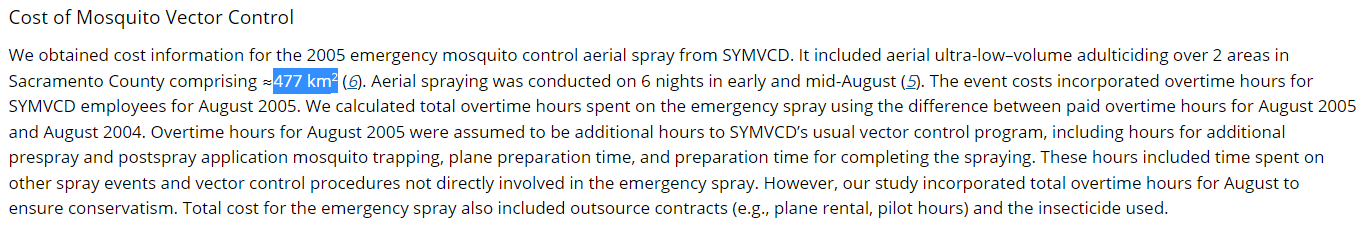
[Source](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article)

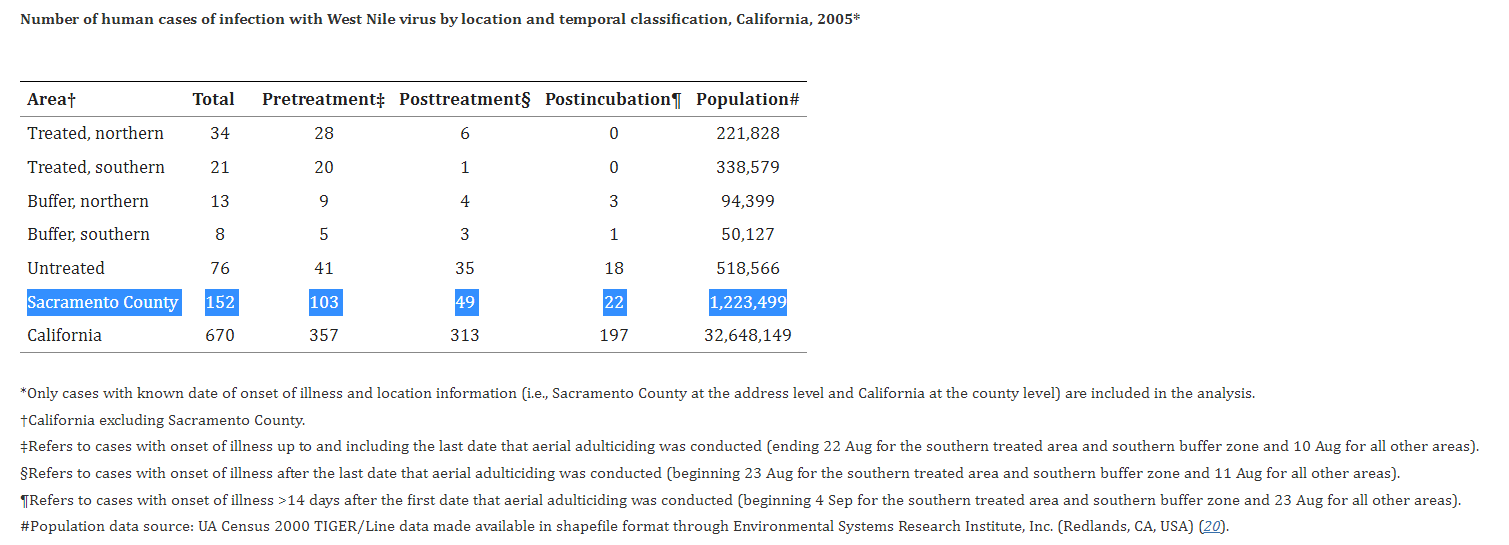
[Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2600250/table/T1/?report=objectonly)

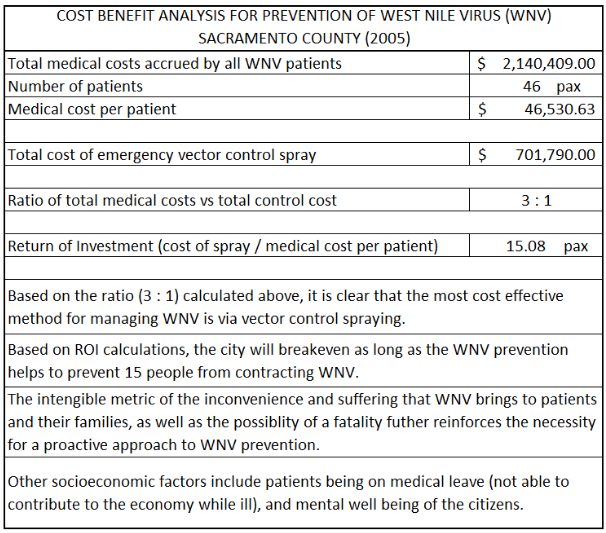
[Source](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article)

|            	|            	|                 	| **Population** 	|            	|                 	|      	|
|------------	|------------	|-----------------	|----------------	|------------	|-----------------	|------	|
|    City    	| Population 	| Density/km^2 		|      Year      	| Population 	| Density/km^2 		| Year 	|
| Sacramento 	| 1,223,499  	| 4,835          	| 2005           	| 2,186,000  	| 8,640          	| 2022 	|
| **Chicago** 	| 8,464,000  	| 13,967          	| 2005           	| 8,901,000  	| **14,688**       	| 2022 	|
[Source](https://www.macrotrends.net/cities/22956/chicago/population)

| Item                           				| Result   		| Remarks            	|
|--------------------------------				|----------		|--------------------	|
| emergency spray cost		    	     	  	| \$899,048 	| excluding overtime  	|
| sprayed area		                	 	  	| 477km^2 		|                    	|
| spray cost per km^2            				|\$1,884.70    		|                    	|
| spray area per trap (1.3km radius) 			| 5.31km^2	 	|                    	|
| **spray cost per trap**            			| **\$10,007.76**	| excluding overtime 	|
| **number of people covered within spray area**| **77,993**	| calculated using spray area per trap * population density|
| likelihood of severe infection				| 522	 		| 1 in 150 cases are severe           	|
| cost for medical treatment 					| \$33,085,926	 	| \$63,383 per pax                   	|
|--------------------------------				|----------		|--------------------	|
| number of traps to spray 			| 4051 	 	| total predicted positive, averaged accross 4 years 2008, 2010, 2012, 2014| 
|total spray cost incurred 			| \$40,541,423.60 	|                    	|


With references from the above sources, emergency spray cost was divided by the area covered by spray to obtain cost/km^2.
We also took note of the estimated patient cost per case. These values were adjusted for inflation for the year 2022.

Using Area and population estimates, we calculated the population density for Chicago. With the trap area coverage estimated to be 5.31km^2, we were able to use the adjusted cost/km^2 to calculate the cost for spraying one trap in Chicago.     

Our AdaBoostClassifier predicted a total of 4051 positive traps/year by dividing total positive classifications with number of years classified (2008,2010,2012,2014).   

With the population density we were also able to calculate potentially the number of possible WNV infections in a given trap and using the rate of 1 in 150 for WNND, we estimate that we were able to save medical costs upwards of 30 million dollars with one spray. Spraying all 4051 traps identified in a given year will cost the CDPH ~$40,000,000.

Assumptions made in this CBA:

- Spray Area covered were not overlapping, as such 100 percent of the population density is applied to every trap for estimated infections predicted. (a flat % can be applied to increase realism, i.e traps have 30% area overlap, by which total Spray Area will become (No. of traps sprayed * (overlap weight(0.7) * 5.31))

- Traps sprayed were assumed to be rid of WNV, of which for every 1 in 150 people might have WNND cases. (if we take 80 percent of cases to be assymptomatic, we can multiply cases covered within spray area by 0.2 and then multiplying 0.00667) to get a more realistic value of medical costs sprayed.

It is unlikely that the state of Chicago has such the budget for spraying every trap identified by the model to be WNV+. Hence it is important to prioritize traps which are linked to the highest population density and not overlapping other traps within its 1.3km radius.

## 11. Recommendations and Conclusions
[Return to top](#Table-of-Contents)

**Recommendations**  
Based on the AdaBoostClassifier predictions and it's identified feature importances, here are our recommendations:

- Identify corresponding traps with lat,long values and commence spraying in a radius of 1.3km around these traps a month in advance prior, with attention given to [maintain spray intervals of not longer than two weeks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2600250/).   


- Positive traps which have another trap in it's vincinity of 1.3km should also be sprayed due to the flight ranged previously researched (referenced in combined EDA notebook) on WNV carrying species (Restuans/ Pipiens).  
      
      
- Better trap laying procedures (Standardized trap locations)   
It was observed during the EDA process that trap locations are seldom similar across years, which might hinder proper identification of areas prone to WNV (consecutive years of WNV+ during peak seasons).  
      
      
- Provision of data in increased quality and quantities   
Data provided for our model to be trained on were only for months to be peak season, it would be better to provide the full range of data for an entire year. Should traps no be tested during winter months, methods can be used to impute the values of these traps ( 0 or mean for past/present year) to better account for the variability of weather data for a given trap.

**Conclusion**

In this project, we cleaned and explored the traps, spray and weather data of Chicago to learn about how each of them plays a part with regards to the mosquito population in Chicago and its relationship to the presence of West Nile Virus(Wnv). Using learned relationships during EDA and visualizations, using the data science process we also used a selection of classifiers to predict potential positive traps to serve as a guide for timely effective allocation of resources.   

The classsification model we trained gave us a decent ROC-AUC score of ~0.778, and very good recall score of ~0.901. We also learned about possible pitfalls when our scores can be seem optimistic but not necessarily predict well on future data when the look ahead bias is introduced. 

In the cost-benefit analysis(CBA) we also explored the quantification of cost when a positive trap misclassified as negative as well as a negative trap misclassfied as positive. Additionally, the CBA also covered the breakeven point in terms of number of WNV cases prevent as a result of spraying for cost justification. We also covered the intangible aspects of the WNV such as the grief and disruption in brings to patients. The potential of WNV to bring about severe life-threathening diseases/risk of permanent disability also highlights the importance of prevention rather than cure as every life lost/ severely disrupted due to WNV is one too many.



https://www.cdc.gov/westnile/prevention/index.html

Moving forward, more geographic and demographics information could also be useful in studying the presence of Wnv. Since Wnv is spread through moquitoes, we could expect that proportion of open water sources, percentage of grass land, forests, and urban landscape are all factors of the livelihood of these mosquitoes. We can expand the studies to the rest of United States with more data on more mosquitoes species as other states have other species as the main vector species.